<a href="https://colab.research.google.com/github/Ccode104/CVN-SGD/blob/main/CVN_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gradient Descent (Standard vs Improved)

## Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

np.random.seed(42) # It is for random number generation.
                   # However, we set the seed to '42' for reproducible results accross multiple runs.

## Get the dataset
<p>You have two options :
<ol>
<li> You can freshly generate the dataset
<li> Load the dataset from a CSV file
</ol>

Make sure to run only one cell fom below for desired effect.</p>

### Generate the dataset with anisotropic noise

In [8]:
# Regression dataset with Gaussian noise (sigma = 10)
X, y = make_regression(n_samples=500, n_features=10, noise=10.0, bias=3.0)

# Add strong anisotropic noise to some coordinates
noise_strength = 15.0
num_noisy_features = 3

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

for i in range(num_noisy_features):
    X_train[:, i] += np.random.normal(0, noise_strength, X_train.shape[0])
    X_test[:, i] += np.random.normal(0, noise_strength, X_test.shape[0])

df_display = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
print("First 5 rows of X:")
print(df_display.head())

csv_file_path = 'generated_dataset.csv'
df_display.to_csv(csv_file_path, index=False)
print(f"Dataset saved to {csv_file_path}")

First 5 rows of X:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.725646  -0.048658   1.062335  -0.119988   0.502802  -0.493820   
1   0.465035  -0.213604  -0.262713   0.076614  -1.570808   0.620051   
2  -1.488329   1.631441  -0.888384  -0.534414   0.437040  -1.571543   
3  -0.372930   0.158451  -2.441516   1.167262  -0.506125   0.385745   
4   0.979286   0.395727   1.167372  -0.395016   1.277700  -0.554827   

   feature_6  feature_7  feature_8  feature_9  
0  -1.358909   1.164039   0.209726  -1.711644  
1  -0.868349   1.037473   0.704384   0.485256  
2  -0.299705  -1.048975  -0.317518   0.256647  
3   1.574641   0.304245   1.255921   0.199125  
4  -0.119579   1.337470   0.946149   1.037018  


### Load existing dataset

In [12]:
from google.colab import files
uploaded = files.upload()  # User selects a file; a file chooser dialog will appear

# Get the user-selected file's name (the file will be uploaded into the Colab environment)
csv_file_path = list(uploaded.keys())[0]

# Now you can load as before:
loaded_df = pd.read_csv(csv_file_path)
print("\nFirst 5 rows of the saved CSV file (from chosen file):")
print(loaded_df.head())


Saving generated_dataset.csv to generated_dataset (1).csv

First 5 rows of the saved CSV file (from chosen file):
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.725646  -0.048658   1.062335  -0.119988   0.502802  -0.493820   
1   0.465035  -0.213604  -0.262713   0.076614  -1.570808   0.620051   
2  -1.488329   1.631441  -0.888384  -0.534414   0.437040  -1.571543   
3  -0.372930   0.158451  -2.441516   1.167262  -0.506125   0.385745   
4   0.979286   0.395727   1.167372  -0.395016   1.277700  -0.554827   

   feature_6  feature_7  feature_8  feature_9  
0  -1.358909   1.164039   0.209726  -1.711644  
1  -0.868349   1.037473   0.704384   0.485256  
2  -0.299705  -1.048975  -0.317518   0.256647  
3   1.574641   0.304245   1.255921   0.199125  
4  -0.119579   1.337470   0.946149   1.037018  


## Define the Standard Gradient Descent

In [ ]:
def standard_gd(X, y, lr=0.008, epochs=1000):
    n_samples, n_features = X.shape
    W = np.zeros(n_features)
    b = 0.0

    train_losses, test_losses, grad_norms, update_norms = [], [], [], []
    param_history = []

    for epoch in range(epochs):
        y_pred = X @ W + b  # Just tried using it instead of np.dot !
        error = y_pred - y

        grad_w = X.T @ error / n_samples
        grad_b = np.sum(error) / n_samples
        grad = np.append(grad_w, grad_b)

        # Save BEFORE update
        param_history.append(np.append(W, b))

        # Metrics
        train_losses.append(mean_squared_error(y, y_pred))
        test_losses.append(mean_squared_error(y_test, X_test @ W + b))
        grad_norms.append(np.linalg.norm(grad))
        update_norms.append(np.linalg.norm(lr * grad))

        # Update
        W -= lr * grad_w
        b -= lr * grad_b

    return {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'grad_norm': grad_norms,
        'update_norm': update_norms,
        'param_history': param_history,
        'W': W, 'b': b
    }

## Improved CVN-SGD Algorithm


In [ ]:
def improved_cvn_sgd(
    X, y, lr=0.01, epochs=1000, beta=0.9, epsilon=1e-8, batch_size=32, clip_value=50.0
):
    n_samples, n_features = X.shape
    W = np.zeros(n_features)
    b = 0.0

    st = np.ones(n_features + 1) * epsilon

    train_losses, test_losses, grad_norms, update_norms = [], [], [], []
    param_history = []

    for epoch in range(epochs):

        # ---- Mini-batch sampling ----
        idx = np.random.choice(n_samples, batch_size, replace=False)
        Xb = X[idx]
        yb = y[idx]

        y_pred = Xb @ W + b
        error = y_pred - yb

        grad_w = Xb.T @ error / batch_size
        grad_b = np.sum(error) / batch_size
        vt = np.append(grad_w, grad_b)

        # ---- Second-moment update ----
        st = beta * st + (1 - beta) * (vt ** 2)
        Dt = 1.0 / (np.sqrt(st) + epsilon)

        # ---- Optional clipping (helps stability) ----
        Dt = np.minimum(Dt, clip_value)

        # Save BEFORE update
        param_history.append(np.append(W, b))

        # ---- Metrics ----
        train_losses.append(mean_squared_error(y, X @ W + b))
        test_losses.append(mean_squared_error(y_test, X_test @ W + b))
        grad_norms.append(np.linalg.norm(vt))
        update_vec = lr * Dt * vt
        update_norms.append(np.linalg.norm(update_vec))

        # ---- Apply update ----
        W -= lr * Dt[:-1] * grad_w
        b -= lr * Dt[-1] * grad_b

    return {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'grad_norm': grad_norms,
        'update_norm': update_norms,
        'param_history': param_history,
        'W': W, 'b': b
    }

## Train(fit) on the dataset

In [ ]:
EPOCHS = 1000
res_gd = standard_gd(X_train, y_train, epochs=EPOCHS)
res_cvn = improved_cvn_sgd(X_train, y_train, epochs=EPOCHS)

epochs = np.arange(EPOCHS)

## Plot the graphs for comparison

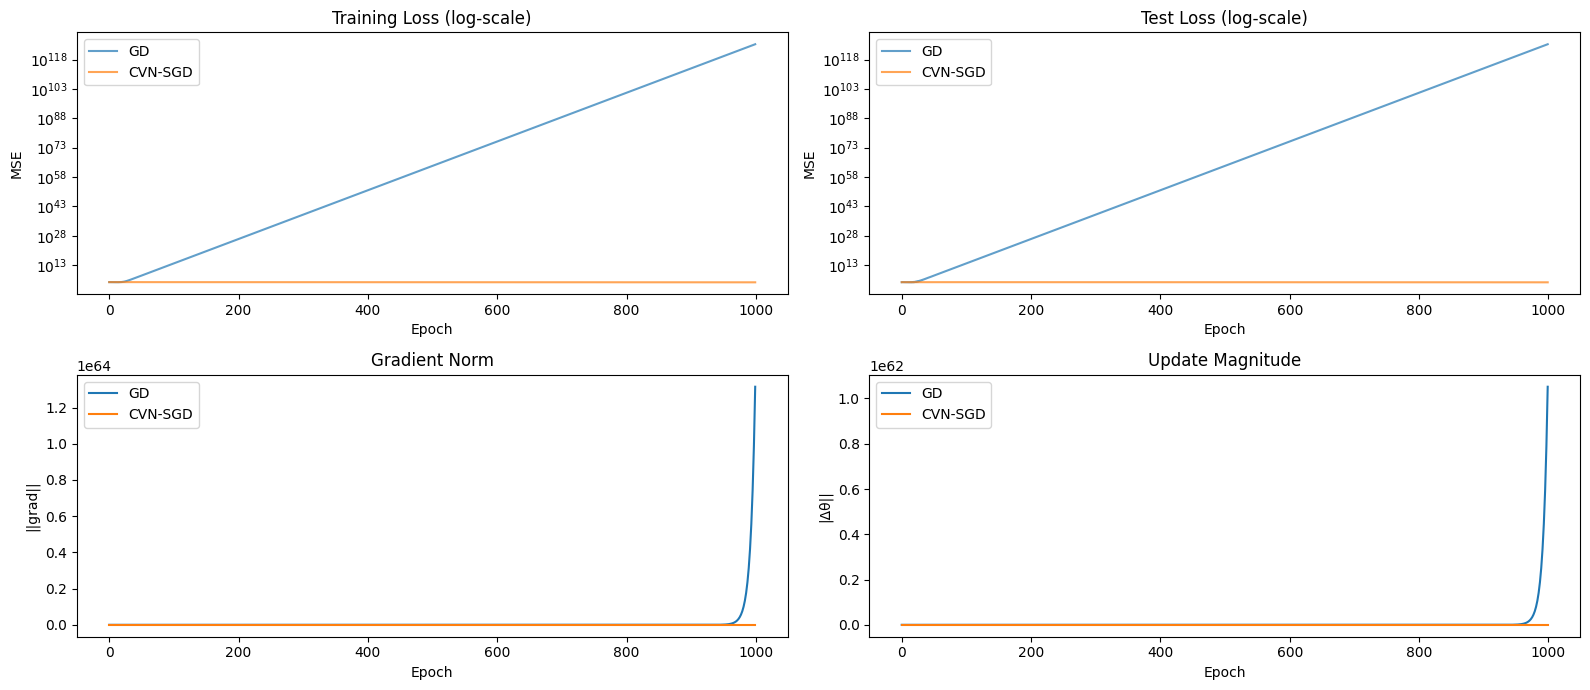

In [ ]:
plt.figure(figsize=(16, 7))

plt.subplot(2, 2, 1)
plt.plot(epochs, res_gd['train_loss'], label="GD", alpha=0.7)
plt.plot(epochs, res_cvn['train_loss'], label="CVN-SGD", alpha=0.7)
plt.yscale("log")
plt.title("Training Loss (log-scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, res_gd['test_loss'], label="GD", alpha=0.7)
plt.plot(epochs, res_cvn['test_loss'], label="CVN-SGD", alpha=0.7)
plt.yscale("log")
plt.title("Test Loss (log-scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, res_gd['grad_norm'], label="GD")
plt.plot(epochs, res_cvn['grad_norm'], label="CVN-SGD")
plt.title("Gradient Norm")
plt.xlabel("Epoch")
plt.ylabel("||grad||")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, res_gd['update_norm'], label="GD")
plt.plot(epochs, res_cvn['update_norm'], label="CVN-SGD")
plt.title("Update Magnitude")
plt.xlabel("Epoch")
plt.ylabel("|\u0394\u03b8||")
plt.legend()

plt.tight_layout()
plt.show()

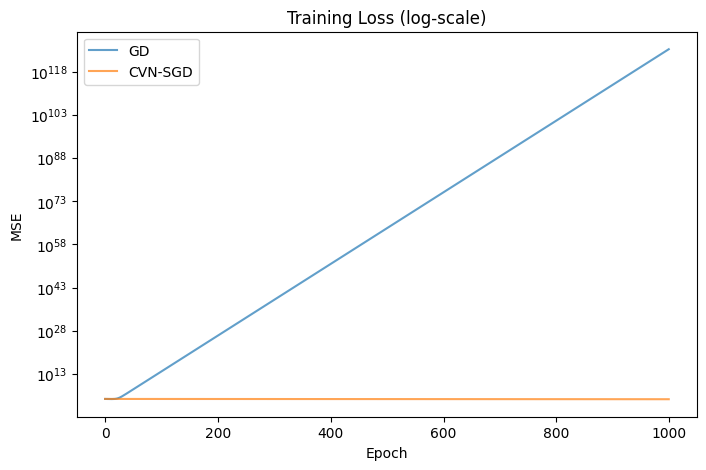

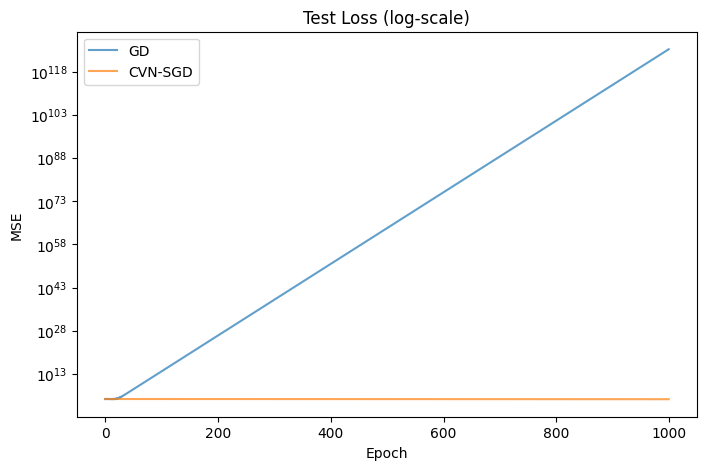

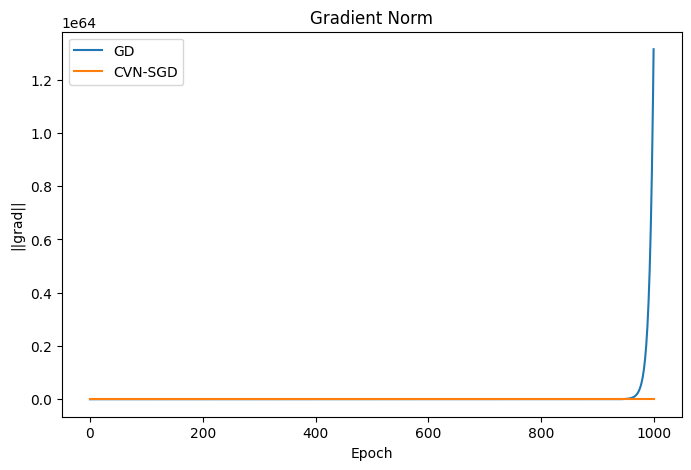

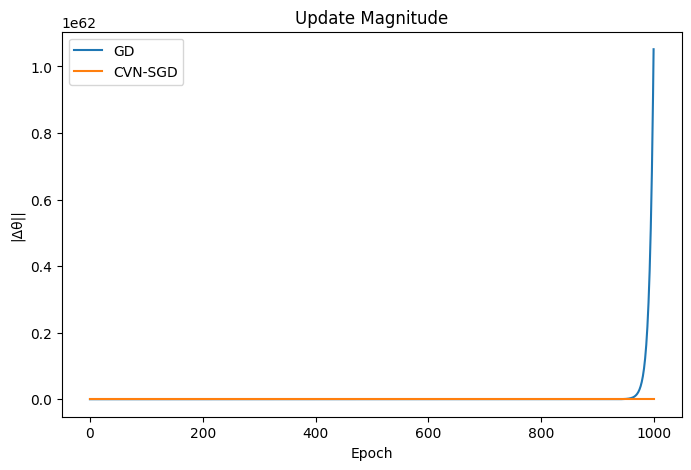

In [13]:
# 1. Training Loss (log-scale)
plt.figure(figsize=(8, 5))
plt.plot(epochs, res_gd['train_loss'], label="GD", alpha=0.7)
plt.plot(epochs, res_cvn['train_loss'], label="CVN-SGD", alpha=0.7)
plt.yscale("log")
plt.title("Training Loss (log-scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# 2. Test Loss (log-scale)
plt.figure(figsize=(8, 5))
plt.plot(epochs, res_gd['test_loss'], label="GD", alpha=0.7)
plt.plot(epochs, res_cvn['test_loss'], label="CVN-SGD", alpha=0.7)
plt.yscale("log")
plt.title("Test Loss (log-scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# 3. Gradient Norm
plt.figure(figsize=(8, 5))
plt.plot(epochs, res_gd['grad_norm'], label="GD")
plt.plot(epochs, res_cvn['grad_norm'], label="CVN-SGD")
plt.title("Gradient Norm")
plt.xlabel("Epoch")
plt.ylabel("||grad||")
plt.legend()
plt.show()

# 4. Update Magnitude
plt.figure(figsize=(8, 5))
plt.plot(epochs, res_gd['update_norm'], label="GD")
plt.plot(epochs, res_cvn['update_norm'], label="CVN-SGD")
plt.title("Update Magnitude")
plt.xlabel("Epoch")
plt.ylabel("|\u0394\u03b8||")
plt.legend()
plt.show()


In [ ]:
df = pd.DataFrame([
    {
        'Strategy': 'Gradient Descent',
        'Final Train Loss': res_gd['train_loss'][-1],
        'Final Test Loss': res_gd['test_loss'][-1],
        'Final Gradient Norm': res_gd['grad_norm'][-1],
        'Final Update Magnitude': res_gd['update_norm'][-1],
    },
    {
        'Strategy': 'CVN-SGD',
        'Final Train Loss': res_cvn['train_loss'][-1],
        'Final Test Loss': res_cvn['test_loss'][-1],
        'Final Gradient Norm': res_cvn['grad_norm'][-1],
        'Final Update Magnitude': res_cvn['update_norm'][-1],
    }
])

df

,Strategy,Final Train Loss,Final Test Loss,Final Gradient Norm,Final Update Magnitude
0,Gradient Descent,6.419779e+125,6.558835e+125,1.314761e+64,1.051809e+62
1,CVN-SGD,1.699173e+04,1.705758e+04,2.138455e+02,1.787316e-02


## Why CVN-SGD Outperforms Standard GD

**Situation where CVN-SGD excels:** When gradient noise is **anisotropic** (high-variance in some coordinates, low-variance in others).

### What we did:
- Added strong Gaussian noise (σ=50) to the **first 3 features only**
- Other 7 features remain relatively clean

### Why this helps CVN-SGD:
1. **Standard GD Problem:** Uses a uniform learning rate across all dimensions. The noisy features slow down convergence because GD must be conservative to avoid divergence on high-variance coordinates.

2. **CVN-SGD Solution:** Uses per-coordinate second-moment normalization (like Adam/RMSProp). It automatically:
   - **Dampens** updates on noisy features (first 3)
   - **Amplifies** updates on clean, informative features (remaining 7)
   - Achieves better effective learning rates per dimension

3. **Theoretical Advantage:** CVN-SGD's convergence rate depends on "effective variance" rather than worst-case variance, leading to faster convergence when noise is concentrated in specific dimensions.

### Real-world applications:
- High-dimensional data with irrelevant/noisy features
- Transfer learning where some pre-trained features are less reliable
- Adversarial or corrupted training data
- Feature engineering scenarios with mixed quality signals